# Credit Card Transaction Analysis
# Aisling Towey

### Analysis Objective & Data Overview
The objective of this analysis is to explore transaction data to identify what characteristics are most closely related to a transaction being fraudulent or not.

The data consists of 10 variables and 594643 observations each representing a transaction either fraudulent or non fraudulent and can be found at https://www.kaggle.com/ntnu-testimon/banksim1#bs140513_032310.csv. As the outcome variable is known and is binary, this is a supervised learning classification problem.

### Import Modules

In [12]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
import os

### Basic Data Exploration

In [13]:
os.chdir('/Users/aislingtowey/Documents/Project/data')

#read in data
fraud = pd.read_csv("A2 data.csv")

#basic eda
print(fraud.head())
print(fraud.info())
print(fraud.shape)
print(type(fraud))
print(fraud.describe())

   step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'    4.55      0  
1  'es_transportation'   39.68      0  
2  'es_transportation'   26.89      0  
3  'es_transportation'   17.25      0  
4  'es_transportation'   35.72      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
step           594643 non-null int64
customer       594643 non-null object
age            594643 non-null object
gender         594643 non-null object
zipcodeOri     594643 non-null object
mer

### Furthur Exploration & Data Preprocessing

In [14]:
#check for missing values
fraud.isnull().sum()

#check for duplicated rows
fraud.duplicated().sum()

#remove zip columns as they have zero variance
fraud.loc[:,["zipMerchant", "zipcodeOri"]]

fraud = fraud.drop(columns=["zipMerchant", "zipcodeOri"]) 

#ensure columns have been dropped
fraud.info()
fraud.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
step        594643 non-null int64
customer    594643 non-null object
age         594643 non-null object
gender      594643 non-null object
merchant    594643 non-null object
category    594643 non-null object
amount      594643 non-null float64
fraud       594643 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 36.3+ MB


,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,0,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,0,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,0,'C757503768','5','M','M348934600','es_transportation',35.72,0


In [15]:
#there appeared to be quotation marks around all columns names which could be removed
#remove all quotation marks in columns where they exist
fraud['customer'] = fraud['customer'].str.strip('\'')
fraud['age'] = fraud['age'].str.strip('\'')
fraud['gender'] = fraud['gender'].str.strip('\'')
fraud['merchant'] = fraud['merchant'].str.strip('\'')
fraud['category'] = fraud['category'].str.strip('\'')

#ensure they have been removed
fraud.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


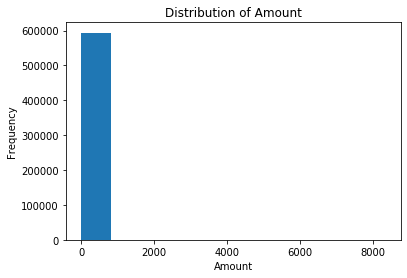

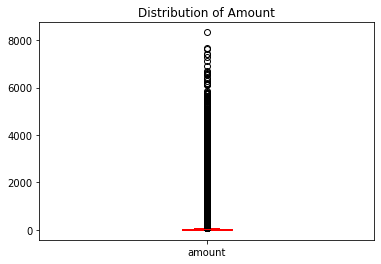

In [16]:
#Check the distribution of the amount variable. Although outliers exist these cannot be removed as it 
#is important to understand the high amount transactions as well as the low amount transactions.
fraud.plot(kind = 'hist', y = 'amount', legend = False)
plt.title("Distribution of Amount")
plt.xlabel("Amount")
plt.show()

#check the distribution of amount
fraud.plot(kind = 'box', y = 'amount', color = 'r')
plt.title("Distribution of Amount")
plt.show()

In [17]:
#Check are there transactions of 0 within amount which could be removed
#52 were found so these were removed as none of them were fradulent
fraud['amount'].loc[fraud.amount == 0].count() 
zero_tran = fraud.loc[fraud.amount == 0]

#check if these 52 transactions are fradulent
zero_tran[['fraud','amount']]
print(fraud.shape)

#remove the amounts equal to 0
fraud = fraud.loc[fraud.amount != 0]

#check the shape to ensure this has happened
print(fraud.shape)

(594643, 8)
(594591, 8)


In [18]:
#explore the age categories
#check the categories within age
fraud.age.unique
fraud["age"].value_counts()

2    187289
3    147115
4    109018
5     62638
1     58130
6     26772
0      2452
U      1177
Name: age, dtype: int64

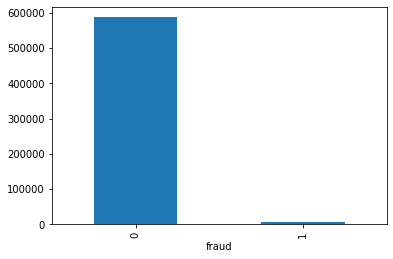

In [19]:
#show the split between fradulent and non fradulent transactions
#there is a large imbalance in the response variable with most transactions non-fraudulent
fraud.groupby('fraud')['fraud'].count().plot(kind = 'bar')

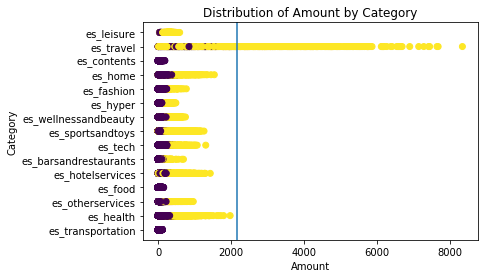

In [20]:
#Check the distribution of amount by category. From the data and the plot it is evident that any transaction with 
#an amount greater than 2150 was fraudulent and was in the travel category.
plt.scatter(fraud.amount, fraud.category, c = fraud.fraud)
plt.axvline(x=2150)
plt.title("Distribution of Amount by Category")
plt.xlabel("Amount")
plt.ylabel("Category")
plt.show()

In [21]:
#Explore the merchant variable
#Note that the top 2 merchants account for approx 500000 transactions and none of these are fradulent
pd.crosstab(fraud.merchant,fraud.fraud)

fraud,0,1
merchant,,
M1053599405,6821,0
M117188757,21,0
M1198415165,1222,358
M1294758098,7,184
M1313686961,527,0
M1352454843,370,0
M1353266412,14,64
M1400236507,776,0
M1416436880,220,0


In [22]:
#Explore the category variable
#Note that no transactions in the transportation, food or contents categories were found to be fraudulent
pd.crosstab(fraud.category,fraud.fraud)

fraud,0,1
category,,
es_barsandrestaurants,6253,120
es_contents,885,0
es_fashion,6338,116
es_food,26250,0
es_health,14437,1696
es_home,1684,302
es_hotelservices,1196,548
es_hyper,5818,280
es_leisure,25,474


In [23]:
#originally was going to use smotenc to balance the dataset but was taking too long on my machine so need to 
#change categoricals to numericals so that smote runs
col_categorical = fraud.select_dtypes(include= ['object']).columns
for col in col_categorical:
    fraud[col] = fraud[col].astype('category')
    
#change categorical values to numeric values
fraud[col_categorical] = fraud[col_categorical].apply(lambda x: x.cat.codes)

#check the types have changed
print(fraud.info())
print(fraud.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594591 entries, 0 to 594642
Data columns (total 8 columns):
step        594591 non-null int64
customer    594591 non-null int16
age         594591 non-null int8
gender      594591 non-null int8
merchant    594591 non-null int8
category    594591 non-null int8
amount      594591 non-null float64
fraud       594591 non-null int64
dtypes: float64(1), int16(1), int64(2), int8(4)
memory usage: 21.5 MB
None
   step  customer  age  gender  merchant  category  amount  fraud
0     0       210    4       2        30        12    4.55      0
1     0      2753    2       2        30        12   39.68      0
2     0      2285    4       1        18        12   26.89      0
3     0      1650    3       2        30        12   17.25      0
4     0      3585    5       2        30        12   35.72      0


### Model Preparation

In [24]:
#split independent and dependent variables
X = fraud.drop(['fraud'],axis=1)
y = fraud['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [25]:
#split the data into a training and test spilt
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.3,random_state=42,shuffle=True,stratify=y)

#check the dimensions of the training and test set
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(X_train.head())

(416213, 7)
(416213,)
(178378, 7)
(178378,)
        step  customer  age  gender  merchant  category  amount
296036    97      3368    3       1        18        12   44.74
84304     31      3033    3       1        30        12   67.23
220856    75      3719    1       1        18        12   51.51
176168    61      3044    2       2        18        12   35.87
321713   104        84    2       2        45         3   32.72


In [26]:
#use smoteNC to balance training dataset
#smotenc should be used instead of smote as there are categorical features
#as mentioned above this was taking too long to run on my machines
#sm = SMOTENC(random_state=42, categorical_features=[1,2,3,4,5])
#X_res, y_res = sm.fit_resample(X_train, y_train)
#print(np.bincount(y_res))

#check the types have changed
fraud.info()

#use smote to balance training dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print(np.bincount(y_res))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594591 entries, 0 to 594642
Data columns (total 8 columns):
step        594591 non-null int64
customer    594591 non-null int16
age         594591 non-null int8
gender      594591 non-null int8
merchant    594591 non-null int8
category    594591 non-null int8
amount      594591 non-null float64
fraud       594591 non-null int64
dtypes: float64(1), int16(1), int64(2), int8(4)
memory usage: 21.5 MB
[411173 411173]


### Random Forest Model

In [28]:
rf= RandomForestClassifier(random_state = 11)

#use grid search to find the best combination of parameters
grid_param = { 
    'n_estimators': [30],
    'criterion': ['gini', 'entropy']
}

clf_rf = GridSearchCV(estimator=rf,  
                     param_grid=grid_param,
                     scoring='f1_macro',
                     cv=3)

#train the model on the balanced data and use the test set to check if it generalises well
clf_rf.fit(X_res, y_res)
rf_predict = clf_rf.predict(X_test)

#check metrics and best parameters
print(classification_report(y_test, rf_predict, digits=3))
print(confusion_matrix(y_test, rf_predict))
print("ROC Score:", roc_auc_score(y_test, rf_predict))
print(f"Best Parameters = {clf_rf.best_params_}")
print(f"Best F1 Score = {clf_rf.best_score_}") 

              precision    recall  f1-score   support

           0      0.998     0.998     0.998    176218
           1      0.827     0.799     0.813      2160

    accuracy                          0.996    178378
   macro avg      0.912     0.899     0.905    178378
weighted avg      0.995     0.996     0.996    178378

[[175857    361]
 [   434   1726]]
ROC Score: 0.8985127375897615
Best Parameters = {'criterion': 'entropy', 'n_estimators': 30}
Best F1 Score = 0.9977393871453092


### Feature Importance

[0.00959113 0.01302536 0.0211465  0.04368291 0.17389152 0.38763188
 0.3510307 ]


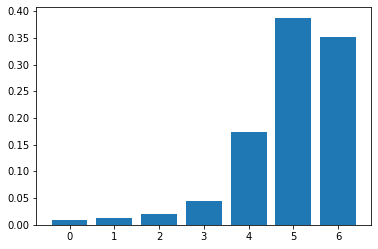

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')
{'step': 0.009591133215456063, 'customer': 0.013025358570089525, 'age': 0.021146496745311674, 'gender': 0.043682911322818346, 'merchant': 0.1738915188255262, 'category': 0.3876318839941044, 'amount': 0.3510306973266938}


In [31]:
#check feature importance of model
#Category, amount and merchant are the 3 most important variables to the model
print(clf_rf.best_estimator_.feature_importances_)
feature_imp = pd.Series(clf_rf.best_estimator_.feature_importances_).sort_values(ascending=False)
feature_imp

plt.bar(range(len(clf_rf.best_estimator_.feature_importances_)), clf_rf.best_estimator_.feature_importances_)
plt.show()

print(fraud.columns)

#one method to get column names beside importance number
print(dict(zip(fraud.columns, clf_rf.best_estimator_.feature_importances_)))


In [32]:
#second method
important_features = pd.Series(data=clf_rf.best_estimator_.feature_importances_,index=X_train.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

category    0.387632
amount      0.351031
merchant    0.173892
gender      0.043683
age         0.021146
customer    0.013025
step        0.009591
dtype: float64


### Conclusion

In conclusion this analysis found that the variables category, amount and merchant were the variables that had characteristics that were closely related to whether a transaction was fraudulent or not. This finding was supported by both the exploratory data analysis and the random forest model. Various other models could be tested to find the best model for prediction in this scenario and paramaters could be tuned. 

The exploratory data analysis found that: any transaction with an amount greater than 2150 was fraudulent and was in the travel category;  no transactions in the transportation, food or contents categories were found to be fraudulent; and all transactions from the top 2 merchants were found to be non-fraudulent meaning fraudulent transactions occurred with merchants that had less transactions.
